# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

In [3]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

from zensols.deeplearn import TorchConfig
# set the random seed so things are predictable
TorchConfig.set_random_seed()

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [5]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn.result import ModelResultGrapher

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris-poor.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config, shared=True)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [6]:
executor = factory('executor')
executor.write()

feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 2 (11.8%)
        test: 3 (17.6%)
        train: 12 (70.6%)
        total: 17
    total this instance: 17
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation if `create_model`.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [7]:
print(executor.create_model())

IrisNetwork(
  (fc): DeepLinearLayer(
    (seq_layers): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

train: 1.439, valid: 0.653 /\: 100%|███████████| 10/10 [00:00<00:00, 51.61it/s]


Name: Iris
Run index: 1
Learning rate: 0.5
    train:
        started: 05/25/2020 23:36:48:524676
        ended: 05/25/2020 23:36:48:719101
        num epochs: 10
        num data points per epoc: 113
        loss: 0.03236556890226152
        num outcomes: 1130
        epoch convergence: 6
        micro: F1: 0.551, precision: 0.55, recall: 0.55
        macro: F1: 0.548, precision: 0.54, recall: 0.55
    validation:
        num epochs: 10
        num data points per epoc: 12
        loss: 0.22381562590599058
        num outcomes: 120
        epoch convergence: 5
        micro: F1: 0.692, precision: 0.69, recall: 0.69
        macro: F1: 0.632, precision: 0.64, recall: 0.69
    test:
        started: 05/25/2020 23:36:48:783343
        ended: 05/25/2020 23:36:48:784952
        num epochs: 1
        num data points per epoc: 25
        loss: 0.03369006443023682
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.880, precision: 0.88, recall: 0.88
        macro: F1: 0.

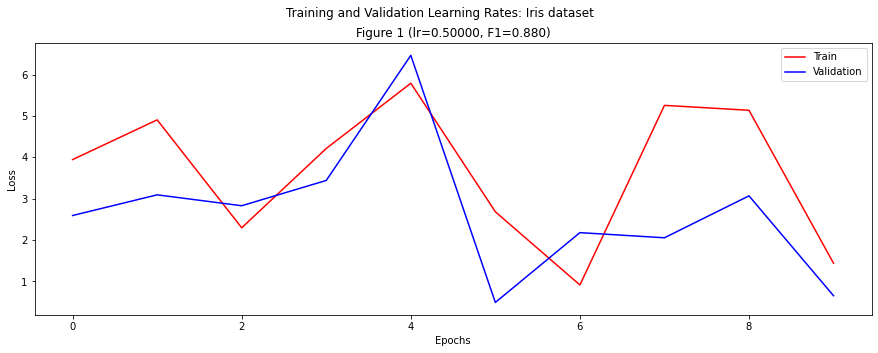

In [8]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the executor.

train: 0.270, valid: 0.308 \/: 100%|█████████| 200/200 [00:19<00:00, 10.15it/s]


Name: Iris
Run index: 2
Learning rate: 0.001
    train:
        started: 05/25/2020 23:40:12:137342
        ended: 05/25/2020 23:40:31:851457
        num epochs: 200
        num data points per epoc: 113
        loss: 0.0032809708116618218
        num outcomes: 22600
        epoch convergence: 199
        micro: F1: 0.895, precision: 0.89, recall: 0.89
        macro: F1: 0.897, precision: 0.90, recall: 0.89
    validation:
        num epochs: 200
        num data points per epoc: 12
        loss: 0.03333966665590802
        num outcomes: 2400
        epoch convergence: 199
        micro: F1: 0.922, precision: 0.92, recall: 0.92
        macro: F1: 0.915, precision: 0.92, recall: 0.92
    test:
        started: 05/25/2020 23:40:32:181246
        ended: 05/25/2020 23:40:32:182815
        num epochs: 1
        num data points per epoc: 25
        loss: 0.011050894498825072
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.880, precision: 0.88, recall: 0.88
        

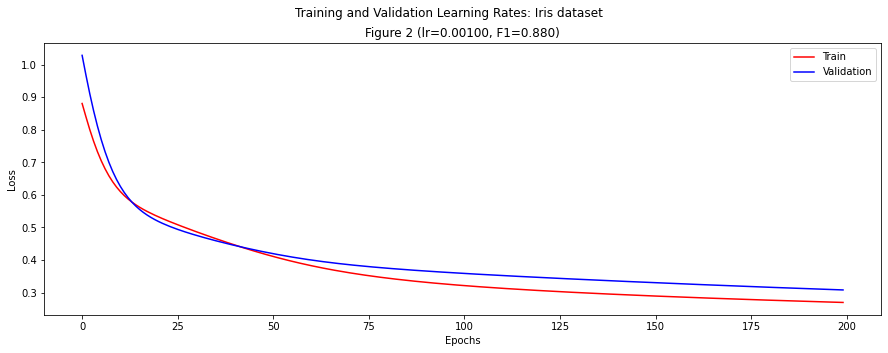

In [12]:
def run_model():
    # reset all state from the previous train/test
    executor.reset()
    # train/test
    executor.train()
    res = executor.test()
    # results
    res.write()
    grapher = ModelResultGrapher('Iris dataset', [15, 5])
    grapher.plot([res])

# set the number of epochs and learning rate, which are both model parameters
executor.set_model_parameter('epochs', 200)
executor.set_model_parameter('learning_rate', .001)

# run the model with the new
run_model()

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't get over training, so add more epochs.

train: 0.371, valid: 0.336 /\: 100%|█████████| 700/700 [00:32<00:00, 21.77it/s]


Name: Iris
Run index: 6
Learning rate: 0.001
    train:
        started: 05/25/2020 23:44:41:424741
        ended: 05/25/2020 23:45:13:579619
        num epochs: 700
        num data points per epoc: 113
        loss: 0.0037043626566195293
        num outcomes: 79100
        epoch convergence: 690
        micro: F1: 0.735, precision: 0.74, recall: 0.74
        macro: F1: 0.733, precision: 0.73, recall: 0.74
    validation:
        num epochs: 700
        num data points per epoc: 12
        loss: 0.03120666771949756
        num outcomes: 8400
        epoch convergence: 680
        micro: F1: 0.973, precision: 0.97, recall: 0.97
        macro: F1: 0.970, precision: 0.97, recall: 0.97
    test:
        started: 05/25/2020 23:45:14:536098
        ended: 05/25/2020 23:45:14:537800
        num epochs: 1
        num data points per epoc: 25
        loss: 0.012493501424789428
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.920, precision: 0.92, recall: 0.92
        

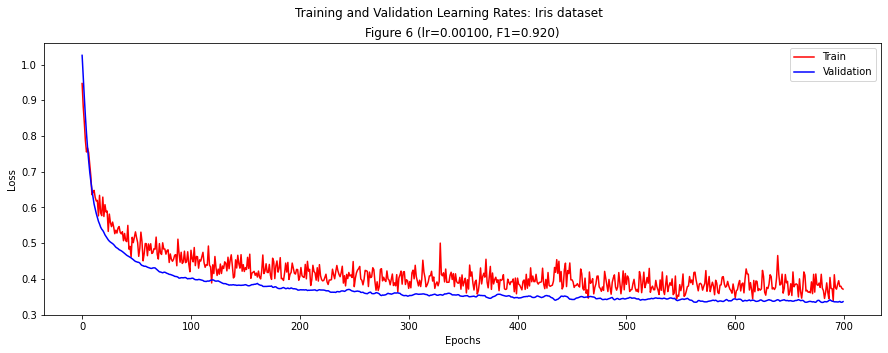

In [17]:
# set a network parameter
executor.set_network_parameter('dropout', 0.1)
executor.set_model_parameter('epochs', 700)
executor.set_model_parameter('learning_rate', .001)
run_model()